In [1]:
import torch
from torch import nn # contains PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(device)

2.1.1+cu121
cuda


# Preparing Data

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split].to(device), y[:train_split].to(device)
X_test, y_test = X[train_split:].to(device), y[train_split:].to(device)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# Predictions Graph

In [4]:
def plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(), test_data=X_test.cpu(), test_labels=y_test.cpu(), predictions=None, title=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    if title is not None:
        plt.title(title)
        
    plt.legend(prop={"size": 14})

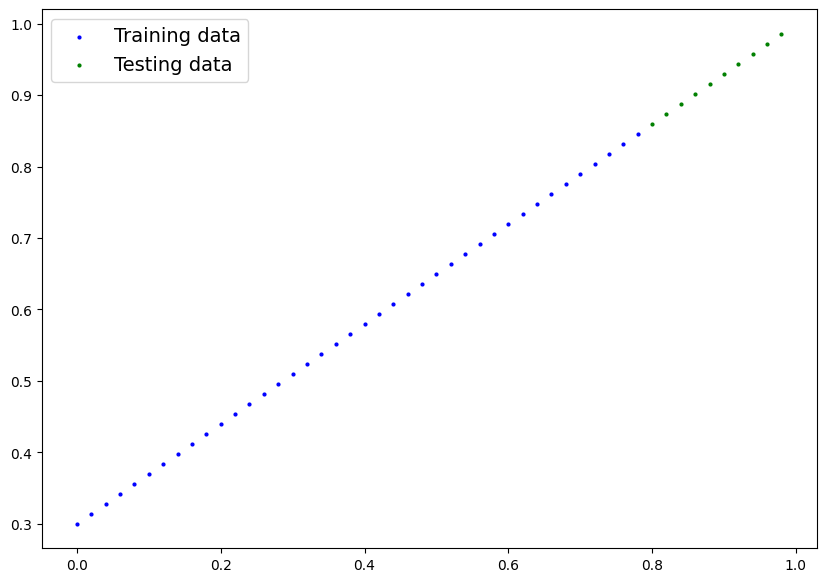

In [5]:
plot_predictions()

# Linear Regression Model
Used to build a standard linear regression model

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [7]:
torch.manual_seed(42)
model_0 = LinearRegressionModel().to(device)
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([0.1288], device='cuda:0', requires_grad=True)],
 OrderedDict([('weight', tensor([0.3367], device='cuda:0')),
              ('bias', tensor([0.1288], device='cuda:0'))]))

## Making Predictions

In [8]:
with torch.inference_mode():
    y_preds = model_0(X_test)

### Check the Predictions

In [9]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='cuda:0')


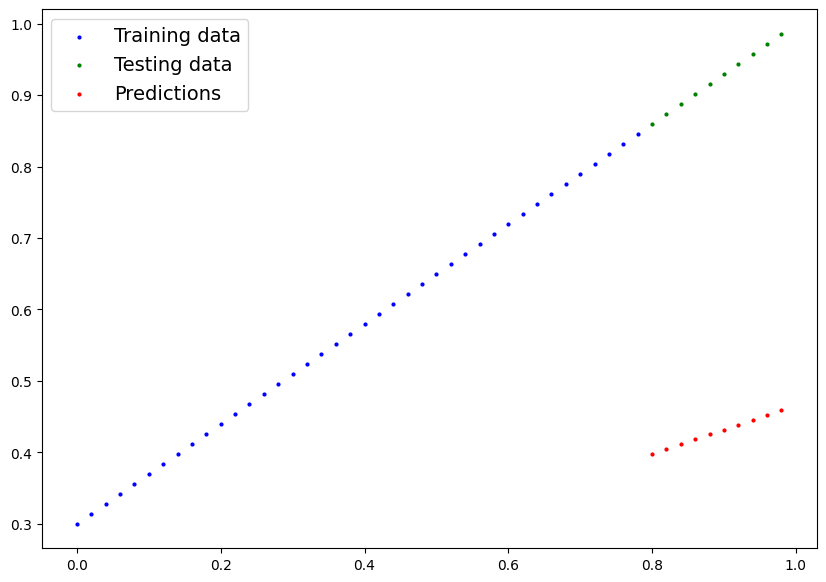

In [10]:
plot_predictions(predictions=y_preds.cpu())

# Loss function and Optimizer

In [11]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001) # lr is learning rate

# Testing and Training Loop

In [12]:
torch.manual_seed(42)

# number of times the model will pass over the training data
epochs = 2000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Training
    
    # Model Training Mode
    model_0.train()
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate  loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    # 4. Backpropagation on the loss
    loss.backward()
    
    # 5. Update optimizer
    optimizer.step()
    
    # Testing
    
    # Model Evaluation Mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288135051727295 | MAE Test Loss: 0.4931890666484833
Epoch: 10 | MAE Train Loss: 0.3013603687286377 | MAE Test Loss: 0.4797181189060211
Epoch: 20 | MAE Train Loss: 0.28983935713768005 | MAE Test Loss: 0.4662471413612366
Epoch: 30 | MAE Train Loss: 0.2783183753490448 | MAE Test Loss: 0.4527761936187744
Epoch: 40 | MAE Train Loss: 0.26679736375808716 | MAE Test Loss: 0.43930521607398987
Epoch: 50 | MAE Train Loss: 0.2552764117717743 | MAE Test Loss: 0.4258342683315277
Epoch: 60 | MAE Train Loss: 0.24375538527965546 | MAE Test Loss: 0.41236335039138794
Epoch: 70 | MAE Train Loss: 0.2322344034910202 | MAE Test Loss: 0.3988923728466034
Epoch: 80 | MAE Train Loss: 0.22071340680122375 | MAE Test Loss: 0.38542142510414124
Epoch: 90 | MAE Train Loss: 0.2091924250125885 | MAE Test Loss: 0.3719504475593567
Epoch: 100 | MAE Train Loss: 0.19767141342163086 | MAE Test Loss: 0.35847947001457214
Epoch: 110 | MAE Train Loss: 0.1861504167318344 | MAE Test Loss: 0.3450085222

# Plot Loss Curves

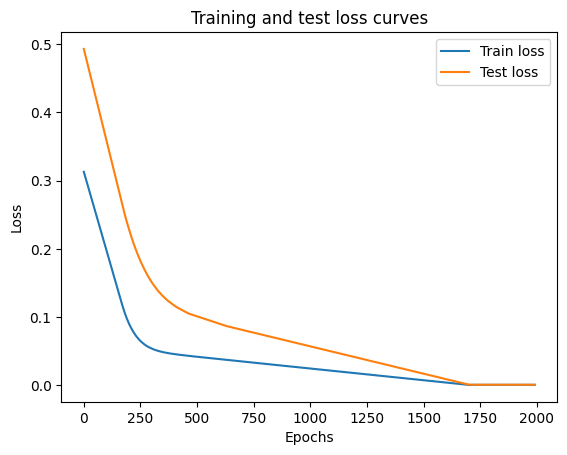

In [13]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [14]:
print("The model learned the following values for weight and bias:")
print(f"Weight: {model_0.state_dict()['weight'][0]} | Bias: {model_0.state_dict()['bias'][0]}")
print("Original values:")
print(f"Weight: {weight} | Bias: {bias}")

The model learned the following values for weight and bias:
Weight: 0.6993508338928223 | Bias: 0.29980868101119995
Original values:
Weight: 0.7 | Bias: 0.3


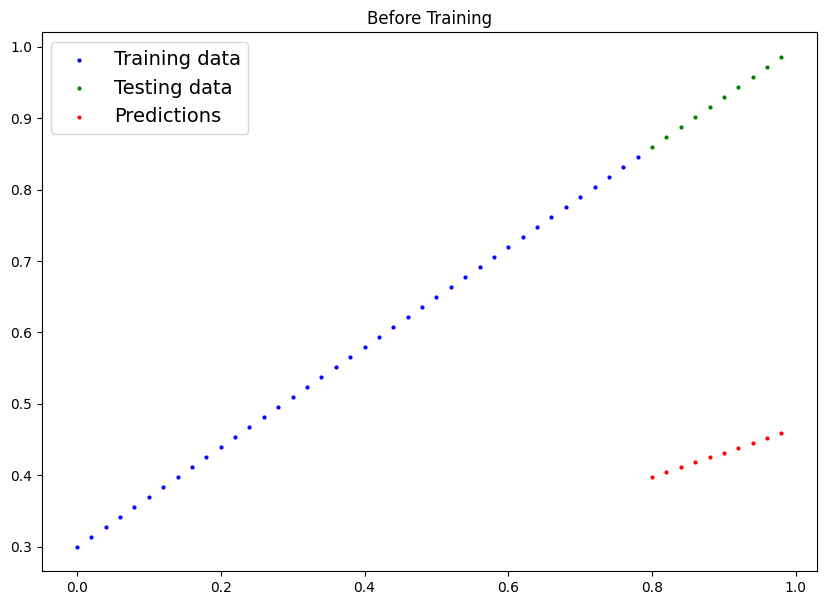

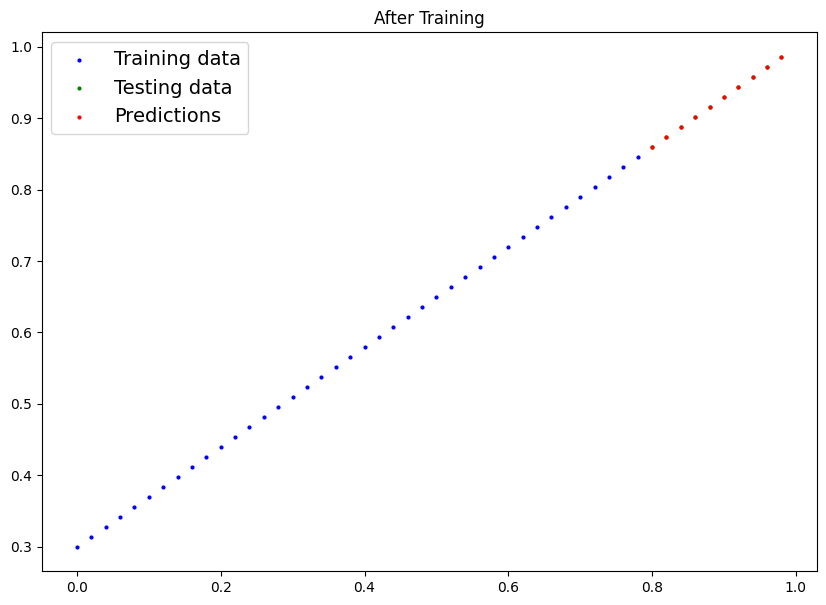

In [15]:
plot_predictions(predictions=y_preds.cpu(), title="Before Training")
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds.cpu(), title="After Training")